In [3]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
Hour_ahead = 24

GBMhourpreRMSE = []
GBMhourpreMAE = []
for a in range(Hour_ahead):

    hour_ahead = a+1
    n_estimators = 111
    learning_rate = 0.01
    Depth = 6
    Min_leaf = 128

    path = "/content/drive/MyDrive/Colab Notebooks/Project/star_data_set.csv"
    Merge_all = pd.read_csv(path)
    dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
    Merge_all.set_index(pd.Index(dti), inplace=True)
    Merge_all.drop(['DateTime'], axis=1, inplace=True)
    First = Merge_all.iloc[0:11000, :]
    N_index = First.shape
    Y_temp = First['FI']
    Y = Y_temp.iloc[hour_ahead:N_index[0]]
    Y = Y.to_numpy()

    X_temp1 = First['FI']
    X_temp2 = First.loc[:, First.columns != 'FI']
    X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
    X_temp2.set_index(X_temp2_index, inplace=True)
    X_temp1 = X_temp1.to_frame()
    X_temp = X_temp1.join(X_temp2)
    X = X_temp.iloc[0:N_index[0] - hour_ahead]
    X = X.to_numpy()
    Pred_index = X.shape
    print("Shape = "+str(Pred_index))



    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



    class DecisionTree():
        def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
            if idxs is None: idxs=np.arange(len(y))
            self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
            self.depth = depth
            #print(f_idxs)
            #         print(self.depth)
            self.n_features = n_features
            self.n, self.c = len(idxs), x.shape[1]
            self.val = np.mean(y[idxs])
            self.score = float('inf')
            self.find_varsplit()

        def find_varsplit(self):
            for i in self.f_idxs: self.find_better_split(i)
            if self.is_leaf: return
            x = self.split_col
            lhs = np.nonzero(x <= self.split)[0]
            rhs = np.nonzero(x > self.split)[0]
            lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
            rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
            self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                    min_leaf=self.min_leaf)
            self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                    min_leaf=self.min_leaf)

        def find_better_split(self, var_idx):
            x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
            sort_idx = np.argsort(x)
            sort_y, sort_x = y[sort_idx], x[sort_idx]
            rhs_sum2: object
            rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
            lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

            for i in range(0, self.n - self.min_leaf - 1):
                xi, yi = sort_x[i], sort_y[i]
                lhs_cnt += 1
                rhs_cnt -= 1
                lhs_sum += yi
                rhs_sum -= yi
                lhs_sum2 += yi ** 2
                rhs_sum2 -= yi ** 2
                if i < self.min_leaf or xi == sort_x[i + 1]:
                    continue

                lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
                rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
                curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
                if curr_score < self.score:
                    self.var_idx, self.score, self.split = var_idx, curr_score, xi

        @property
        def split_name(self):
            return self.x.columns[self.var_idx]

        @property
        def split_col(self):
            return self.x[self.idxs, self.var_idx]

        @property
        def is_leaf(self):
            return self.score == float('inf') or self.depth <= 0

        def predict(self, x):
            return np.array([self.predict_row(xi) for xi in x])

        def predict_row(self, xi):
            if self.is_leaf: return self.val
            t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
            return t.predict_row(xi)

    def std_agg(cnt, s1, s2):
        try:
            return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
        except:
            return 0

    xi = X_train
    train_index = X_train.shape
    yi = y_train - np.mean(y_train)
    ei = 0  # initialization of error
    predf = np.mean(y_train)  # initial prediction 0


    def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
        idxs = np.random.permutation(len(y))[:sample_sz]
        f_idxs = np.random.permutation(x.shape[1])[:n_features]
        return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                            idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


    print("hour_ahead = " + str(hour_ahead))
    print("n_estimators = " + str(n_estimators))
    print("learning_rate = " + str(learning_rate))
    print("Depth = " + str(Depth))
    print("Min_leaf = " + str(Min_leaf))


    trees = []
    for i in range(n_estimators):
        tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
        predi = tree.predict(xi)
        predf = predf + learning_rate * predi
        print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
        ei = y_train - predf  # needed originl y here as residual always from original y
        yi = ei  # update yi as residual to reloop
        trees.append(tree)


    MSE = mean_squared_error(y_train, predf, squared=True)
    print("Training MSE  " + str(MSE))
    RMSE = np.sqrt(MSE)
    print("Training RMSE  " + str(RMSE))
    MAE = mean_absolute_error(y_train, predf)
    print("Training MAE  " + str(MAE))



    xi = X_test
    train_index = X_test.shape
    yi = y_test - np.mean(y_test)
    ei = 0  # initialization of error
    predf = np.mean(y_test)

    i = 0
    for t in trees:
        predi = t.predict(X_test)
        predf = predf + learning_rate * predi
        print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
        ei = y_test - predf  # needed originl y here as residual always from original y
        yi = ei  # update yi as residual to reloop

        #if i == 6:
        #   break
        i += 1


    MSE = mean_squared_error(y_test, predf, squared=True)
    print("Testing MSE  " + str(MSE))
    RMSE = np.sqrt(MSE)
    print("Testing RMSE  " + str(RMSE))
    MAE = mean_absolute_error(y_test, predf)
    print("Testing MAE  " + str(MAE))

    GBMhourpreRMSE.append(RMSE)
    GBMhourpreMAE.append(MAE)

print(GBMhourpreRMSE)
print(GBMhourpreMAE)



เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
30  7.13024353961425
31  7.111816185194636
32  7.092224850021969
33  7.074437083273872
34  7.057612832495061
35  7.040854170733335
36  7.023189205196662
37  7.006031774809344
38  6.9901488880555585
39  6.97458226480532
40  6.9582752546321345
41  6.943420893713795
42  6.928920128359499
43  6.913608299598594
44  6.899879607186437
45  6.886562103087603
46  6.873325559340746
47  6.860458012962998
48  6.849669231228271
49  6.839244949140546
50  6.829195638934106
51  6.819589233161615
52  6.810121400871783
53  6.800824018890911
54  6.791877119058243
55  6.783192212204436
56  6.774821359818198
57  6.766691147121482
58  6.758830109288005
59  6.751143986188596
60  6.743874993133353
61  6.736816588701264
62  6.729951319254547
63  6.723332067853531
64  6.7169574592603665
65  6.710923412908891
66  6.705134408951682
67  6.69971466416435
68  6.694502089703654
69  6.689475446673395
70  6.684714632834834
71  6.68031494923822
72  6.67614839104610

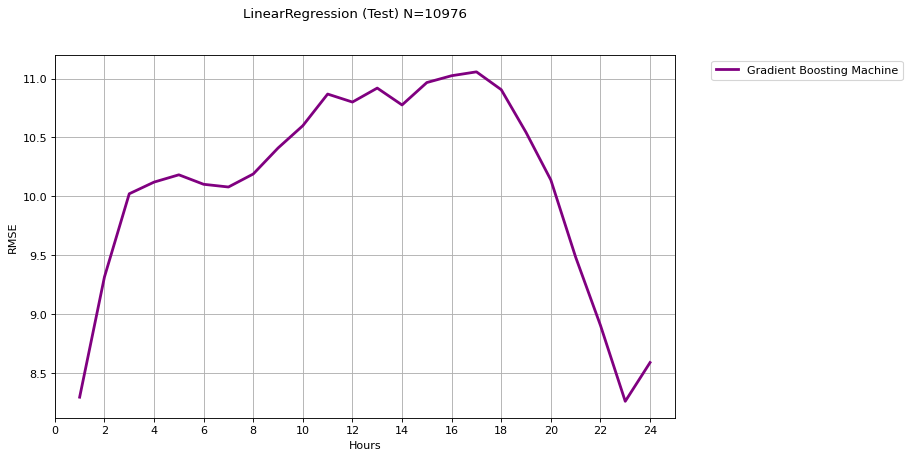

In [5]:
plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('LinearRegression (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(GBMhourpreRMSE))+1, GBMhourpreRMSE, color="purple", linewidth=2.5, linestyle="-", label='Gradient Boosting Machine')
plt.xlabel('Hours')
plt.ylabel('RMSE')
plt.grid(linestyle='-')
plt.xlim(0, Hour_ahead+1)  
plt.xticks(np.arange(0, len(GBMhourpreRMSE)+1, 2.0))
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

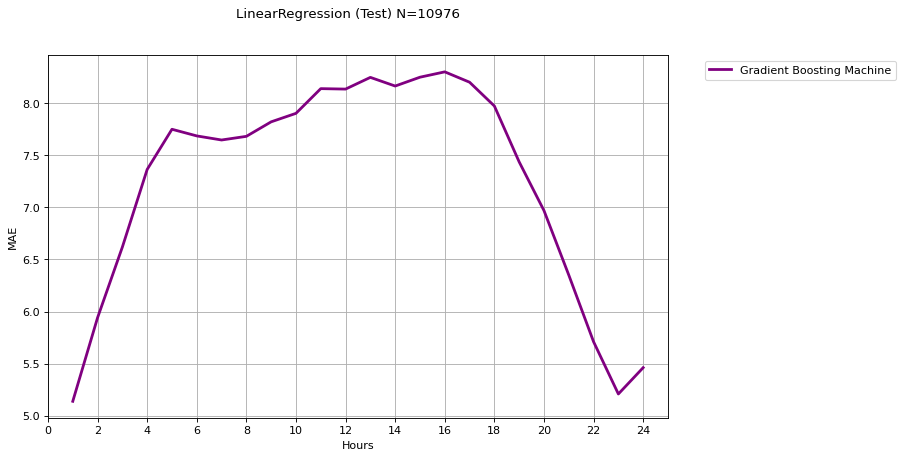

In [6]:
plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('LinearRegression (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(GBMhourpreMAE))+1, GBMhourpreMAE, color="purple", linewidth=2.5, linestyle="-", label='Gradient Boosting Machine')
plt.xlabel('Hours')
plt.ylabel('MAE')
plt.grid(linestyle='-')
plt.xlim(0, Hour_ahead+1)  
plt.xticks(np.arange(0, len(GBMhourpreMAE)+1, 2.0))
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()